In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os

import algorithms
import plotting

from numpy.random import default_rng

In [2]:
# Global varaibles
seed = 909123 # Seed for reproducibility
img_dir = "images"

gd_color = "C0"
sam_color = "red"
ada_color = "green"
r_color = "purple"

gd_label = "GD"
sam_label = "SAM"
ada_label = "AdaGrad"
r_label = "Robustified"

In [3]:
def eigenvalues(A: np.ndarray):
    """Computes positive eigenvalues of the 2x2 matrix A"""
    tr = A[0, 0] + A[1, 1]
    det = A[0, 0]*A[1, 1] - A[0, 1] * A[1, 0]
    delta = tr*tr - 4*det
    assert delta >= 0, "Must have eigen values."
    e1, e2 = (tr - np.sqrt(delta))/2, (tr + np.sqrt(delta))/2
    assert e1 > 0 and e2 > 0, "Eigen values must be positive."
    return e1, e2

def quad_matrix(a11: float = 0, a12: float = 0, a22: float = 0):
    A = np.array([[a11, a12], [a12, a22]])
    eigens = np.linalg.eigvals(A) # eigenvalues(A)
    L, c = np.amax(eigens), np.amin(eigens)
    return A, L, c

def diag_matrix(diag: np.ndarray):
    assert np.all(np.asarray(diag) > 0), "All eignevalues must be positive."
    A = np.diag(np.sort(diag)[..., ::-1])
    return A, np.max(diag), np.min(diag)

def loss(w: np.ndarray, A: np.ndarray):
    return (w @ A @ w.T).diagonal() / 2

def robust_loss(w: np.ndarray, A: np.ndarray, rho: float):
    X = np.sqrt(A)
    X_dagger = np.linalg.inv(X)
    
    norm1 = np.linalg.norm(w @ X, axis=-1)
    norm2 = np.linalg.norm(w @ X @ X_dagger, axis=-1)
    
    return np.square(norm1 + rho * norm1 / (norm2 + 1e-16))
    
def loss_2d(w: np.ndarray, d: int, indices: np.ndarray, loss_func: callable):
    assert len(indices) == 2
    assert w.shape[-1] == 2
    extended_w = np.zeros(w.shape[:-1] + (d,))
    extended_w[..., indices] = w
    return loss_func(extended_w)

def robust_grad(w: np.ndarray, A: np.ndarray, rho: float):
    d = A.shape[0]
    X, y = np.sqrt(A), np.zeros(d)
    X_dagger = np.linalg.inv(X)
    residuals = (y - w @ X.T)
    Xd_y_norm = np.linalg.norm(residuals @ X_dagger.T, axis=-1)
    
    sup_X_dagger = np.expand_dims(X_dagger.copy(), axis=0)
    X_T = np.expand_dims(X.T, axis=0)
    if w.ndim > 1:
        sup_X_dagger = np.full((w.shape[0], d, d), sup_X_dagger)
        X_T = np.full((w.shape[0], d, d), X_T)

    left_scalar = 2 * rho * loss(w, A) * (Xd_y_norm + rho) / np.power(Xd_y_norm, 4)
    left = left_scalar[:, None, None] * sup_X_dagger
    right = np.square(1 + rho / (Xd_y_norm + 1e-8))[:, None, None] * X_T
    expanded_residuals = np.expand_dims(residuals, axis=-1)
    
    grad = 2 * (left - right) @ expanded_residuals
    return grad.squeeze()


def grad(w: np.ndarray, A: np.ndarray):
    return w @ A

def compute_residuals_ratios(w: np.ndarray):
    sq = np.square(w)
    rr = np.array([sq[..., j] / (sq[..., -1] + 1e-8) for j in range(sq.shape[-1] - 1)])
    return rr.squeeze()

# Variables creation

In [37]:
rng = default_rng(seed=seed)

d = 2
bad_cond = True
A, L, l = diag_matrix(rng.random(size=d) + 1)
if bad_cond:
    scale = np.linspace(3, 1, d)
    A, L, l = diag_matrix(A.diagonal() * scale)

# print(A, L, l)
# A, L, c = quad_matrix(a11=4, a22=1)
loss_func = lambda x: loss(x,A)
robust_loss_func = lambda x, rho: robust_loss(x, A, rho)
grad_func = lambda x: grad(x,A)
robust_grad_func = lambda x, rho: robust_grad(x, A, rho)
n_iter = 100
N = 300
# step_size = 1 / (2 * L)
rho = 1

beta0s = rng.normal(scale=3, size=(N, d))
print(f"Singular values: {A.diagonal()}")
print(f"Conditioning: {L / l}")

Singular values: [4.62007574 1.31102364]
Conditioning: 3.524021698165296


# Gradient sanity check

In [38]:
c = 0.5
m, M, h = -c, c, 100
divsX = int((M - m) * h) + 1
divsY = int((M - m) * h) + 1

xv, yv = np.meshgrid(np.linspace(m, M, divsX), np.linspace(m, M, divsY))
zv = np.stack([xv, yv], axis=-1).reshape(divsX * divsY, 2)

# zs = loss_2d(zv, d, [0, -1], loss_func).reshape(divsY, divsX)
# grads = grad_func(zv).reshape(divsY, divsX, 2)
zs = loss_2d(zv, d, [0, -1], lambda y: robust_loss_func(y, rho)).reshape(divsY, divsX)
grads = robust_grad_func(zv, rho).reshape(divsY, divsX, 2)

diff_grads = np.stack(np.gradient(zs, (M - m) / (divsX - 1), (M - m) / (divsY - 1), axis=(1, 0), edge_order=2), axis=2)

# print(diff_grads[0, 0], grads[0, 0], np.abs(diff_grads - grads)[0, 0])
# print(zs.shape, diff_grads.shape, grads.shape)
for j in range(10):
    prop = (np.abs(diff_grads - grads) < 10 ** (-j)).sum() / (divsX * divsY * 2)
    all_close = np.allclose(diff_grads, grads, atol=1**(-j), rtol=0)
    print(f"1e-{j}:\t {all_close} ({prop * 100:.3f}%)")

1e-0:	 False (99.284%)
1e-1:	 False (96.402%)
1e-2:	 False (81.698%)
1e-3:	 False (28.193%)
1e-4:	 False (5.588%)
1e-5:	 False (2.108%)
1e-6:	 False (1.225%)
1e-7:	 False (0.980%)
1e-8:	 False (0.980%)
1e-9:	 False (0.980%)


/tmp/ipykernel_11943/1716231474.py:54: RuntimeWarning: invalid value encountered in divide
  left_scalar = 2 * rho * loss(w, A) * (Xd_y_norm + rho) / np.power(Xd_y_norm, 4)


# Step size grid search w.r.t. residuals ratio

In [39]:
gs_iter = 5
gs_size = 101
gs_N = 500
gs_rho_size = 3
gs_step_sizes = np.linspace(2 / (L + l), 0, gs_size, endpoint=False)
gs_rhos = np.linspace(10, 1, gs_rho_size) #, endpoint=False)

xv, yv = np.meshgrid(gs_step_sizes, gs_rhos)
gs_mixed_values = np.stack([xv, yv], axis=-1)

gs_beta0s = rng.normal(scale=L, size=(gs_N, d))

def get_step_size_score_func(algo):
    def _score_func(step_size):
        gs_betas, _ = algo(gs_iter, gs_beta0s, loss_func, grad_func, step_size)
        gs_rr = compute_residuals_ratios(gs_betas)
        return gs_rr.max(axis=0).min()
    return _score_func

def get_mixed_score_func(algo, grad_func=grad_func):
    def _score_func(step_size, rho):
        # def dec_step_size(k):
        #     return step_size / (k + 1)
        gs_betas, _ = algo(gs_iter, gs_beta0s, loss_func, grad_func, step_size, rho)
        gs_rr = compute_residuals_ratios(gs_betas)
        return gs_rr.max(axis=0).min()
    return _score_func


gd_step_size, gs_gd_scores = algorithms.grid_search(get_step_size_score_func(algorithms.sgd), gs_step_sizes)
(sam_step_size, sam_rho), gs_sam_scores = algorithms.grid_search(get_mixed_score_func(algorithms.sam), gs_mixed_values)
ada_step_size, gs_ada_scores = algorithms.grid_search(get_step_size_score_func(algorithms.adagrad), gs_step_sizes)
(r_step_size, r_rho), gs_r_scores = algorithms.grid_search(get_mixed_score_func(algorithms.min_max, grad_func=robust_grad_func), gs_mixed_values)

gs_sam_step_size_scores = gs_sam_scores[np.where(gs_rhos == sam_rho)][0]
gs_r_step_size_scores = gs_r_scores[np.where(gs_rhos == r_rho)][0]

print(f"{gd_label}:\n\tstep_size: {gd_step_size} (1/L? {np.isclose(gd_step_size, 1/L)})")
print(f"{sam_label}:\n\tstep_size: {sam_step_size}\n\trho: {sam_rho} (smallest? {np.isclose(sam_rho, gs_rhos.min())})")
print(f"{ada_label}:\n\tstep_size: {ada_step_size}")
print(f"{r_label}:\n\tstep_size: {r_step_size}\n\trho: {r_rho} (smallest? {np.isclose(r_rho, gs_rhos.min())})")

GD:
	step_size: 0.21701351301595523 (1/L? False)
SAM:
	step_size: 0.08680540520638208
	rho: 1.0 (smallest? True)
AdaGrad:
	step_size: 0.17027214098174948
Robustified:
	step_size: 0.023370686017102904
	rho: 5.5 (smallest? False)


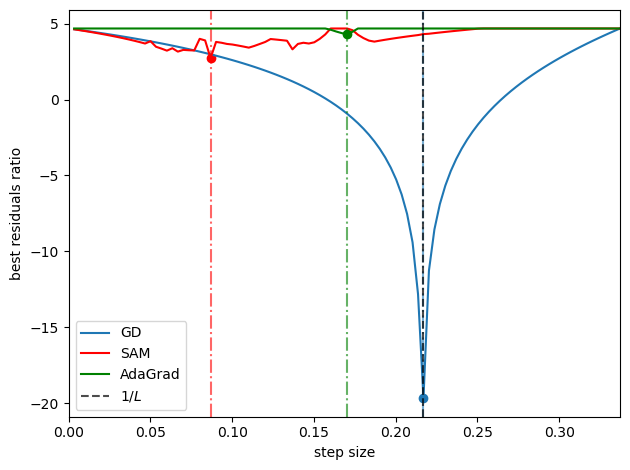

In [50]:
fig, ax = plt.subplots(layout="tight")

ax.plot(gs_step_sizes, np.log10(gs_gd_scores), color=gd_color, label=gd_label)
ax.scatter(gd_step_size, np.log10(gs_gd_scores.min()), color=gd_color)
ax.axvline(gd_step_size, color=gd_color, ls='-.', alpha=.6)

ax.plot(gs_step_sizes, np.log10(gs_sam_step_size_scores), color=sam_color, label=sam_label)
ax.scatter(sam_step_size, np.log10(gs_sam_step_size_scores.min()), color=sam_color)
ax.axvline(sam_step_size, color=sam_color, ls='-.', alpha=.6)

ax.plot(gs_step_sizes, np.log10(gs_ada_scores), color=ada_color, label=ada_label)
ax.scatter(ada_step_size, np.log10(gs_ada_scores.min()), color=ada_color)
ax.axvline(ada_step_size, color=ada_color, ls='-.', alpha=.6)

# ax.plot(gs_step_sizes, np.log10(gs_r_step_size_scores), color=r_color, label=r_label)
# ax.scatter(r_step_size, np.log10(gs_r_step_size_scores.min()), color=r_color)
# ax.axvline(r_step_size, color=r_color, ls='-.', alpha=.6)

ax.axvline(1 / L, ls='--', color="black", alpha=.7, label=r"$1 / L$")

ax.set_xlim(0, 2 / (L + l))
ax.set_xlabel("step size")
ax.set_ylabel("best residuals ratio")
ax.legend()

path = os.path.join(img_dir, "quad_mixed_gs.pdf")
fig.savefig(path)

plt.show()

# Algorithms

In [41]:
gd_betas, gd_losses = algorithms.sgd(n_iter, beta0s, loss_func, grad_func, gd_step_size)
gd_rrs = compute_residuals_ratios(gd_betas)

print('-' * 20 + f" {gd_label} " + '-' * 20)
print(f"Betas: {gd_betas.shape}")
print(f"Losses: {gd_losses.shape}")
print(f"\tMean end loss: {gd_losses[:,-1].mean()}")
print(f"Residuals ratio: {gd_rrs.shape}")

-------------------- GD --------------------
Betas: (300, 63, 2)
Losses: (300, 63)
	Mean end loss: 5.250809430608483e-18
Residuals ratio: (300, 63)


In [42]:
sam_betas, sam_losses = algorithms.sam(n_iter, beta0s, loss_func, grad_func, sam_step_size, sam_rho)
sam_rrs = compute_residuals_ratios(sam_betas)

print('-'*20 + f" {sam_label} " + '-'*20)
print(f"Betas: {sam_betas.shape}")
print(f"Losses: {sam_losses.shape}")
print(f"\tMean end loss: {sam_losses[:,-1].mean()}")
print(f"Residuals ratio: {sam_rrs.shape}")

-------------------- SAM --------------------
Betas: (300, 101, 2)
Losses: (300, 101)
	Mean end loss: 0.1453247985866188
Residuals ratio: (300, 101)


In [43]:
ada_betas, ada_losses = algorithms.adagrad(n_iter, beta0s, loss_func, grad_func, ada_step_size)
ada_rrs = compute_residuals_ratios(ada_betas)

print('-'*20 + f" {ada_label} " + '-'*20)
print(f"Betas: {ada_betas.shape}")
print(f"Losses: {ada_losses.shape}")
print(f"\tMean end loss: {ada_losses[:,-1].mean()}")
print(f"Residuals ratio: {ada_rrs.shape}")

-------------------- AdaGrad --------------------
Betas: (300, 101, 2)
Losses: (300, 101)
	Mean end loss: 5.749658603002024
Residuals ratio: (300, 101)


In [44]:
def dec_step_size(k):
    return r_step_size / (k + 1)

r_betas, r_losses = algorithms.min_max(n_iter, beta0s, loss_func, robust_grad_func, dec_step_size, r_rho)
r_rrs = compute_residuals_ratios(r_betas)

print('-' * 20 + f" {r_label} " + '-' * 20)
print(f"Betas: {r_betas.shape}")
print(f"Losses: {r_losses.shape}")
print(f"\tMean end loss: {r_losses[:,-1].mean()}")
print(f"Residuals ratio: {r_rrs.shape}")

-------------------- Robustified --------------------
Betas: (300, 101, 2)
Losses: (300, 101)
	Mean end loss: 1.574140423754594
Residuals ratio: (300, 101)


# Trajectories

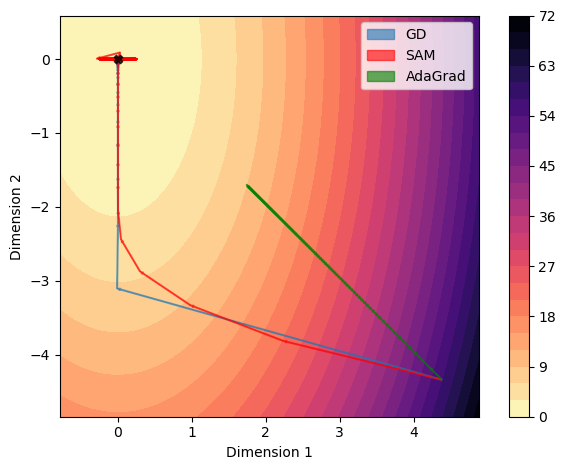

In [52]:
shared_traj_idx = 2
gd_ex = gd_betas[shared_traj_idx]
sam_ex = sam_betas[shared_traj_idx]
ada_ex = ada_betas[shared_traj_idx]
r_ex = r_betas[shared_traj_idx]
minimizer = np.zeros(d)

for dim in range(d - 1):
    to_plot = [gd_ex.reshape(gd_ex.size // d, d),
               sam_ex.reshape(sam_ex.size // d, d),
               ada_ex.reshape(ada_ex.size // d, d),
               # r_ex.reshape(r_ex.size // d, d),
               minimizer.reshape(1, d)]

    mM = plotting.get_mM_around_trajectory(np.concatenate(to_plot), indices=(dim, -1))
    loss_2d_func = lambda x: loss_2d(x, d, (dim, -1), loss_func=loss_func)

    fig, ax = plt.subplots(layout="tight")

    cl = plotting.contour_loss(ax, loss_2d_func, mM, contour_levels=25)
    plotting.plot_arrows(ax, gd_ex[:, dim], gd_ex[:, -1], color=gd_color, alpha=.6, label=gd_label)
    plotting.plot_arrows(ax, sam_ex[:, dim], sam_ex[:, -1], color=sam_color, alpha=.6, label=sam_label)
    plotting.plot_arrows(ax, ada_ex[:, dim], ada_ex[:, -1], color=ada_color, alpha=.6, label=ada_label)
    # plotting.plot_arrows(ax, r_ex[:, dim], r_ex[:, -1], color=r_color, alpha=.6, label=r_label)
    plotting.plot_minimizer(ax, minimizer=minimizer)

    fig.colorbar(cl)
    
    ax.set_xlabel(f"Dimension {dim + 1}")
    ax.set_ylabel(f"Dimension {d}")
    ax.legend()
    ax.set_aspect("equal", "box")

    path = os.path.join(img_dir, f"quad_mixed_trajectories_dim{dim + 1}.pdf")
    fig.savefig(path)

plt.show()

# Residuals ratio

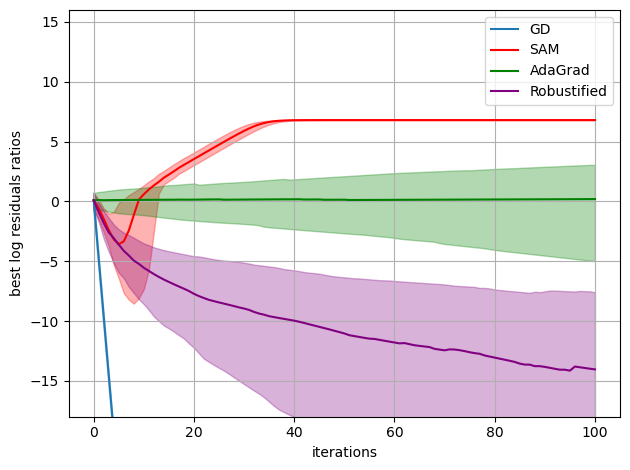

In [49]:
gd_rr = gd_rrs if gd_rrs.ndim <= 2 else gd_rrs.min(axis=0)
sam_rr = sam_rrs if sam_rrs.ndim <= 2 else sam_rrs.min(axis=0)
ada_rr = ada_rrs if ada_rrs.ndim <= 2 else ada_rrs.min(axis=0)
r_rr = r_rrs if r_rrs.ndim <= 2 else r_rrs.min(axis=0)

fig, ax = plt.subplots(layout="tight")

plotting.plot_rr(ax, gd_rr, shared_color=gd_color, label=gd_label)
plotting.plot_rr(ax, sam_rr, shared_color=sam_color, label=sam_label)
plotting.plot_rr(ax, ada_rr, shared_color=ada_color, label=ada_label)
plotting.plot_rr(ax, r_rr, shared_color=r_color, label=r_label)

ax.set_ylabel("best log residuals ratios")
ax.set_xlabel("iterations")
ax.set_ylim(-18, 16)
ax.grid("on")
ax.legend()

path = os.path.join(img_dir, "quad_mixed_log_residuals_ratio.pdf")
fig.savefig(path)

plt.show()

### Edge case

In [14]:
ec_beta0s = np.array([[.5, 1.5], [2, 1.7], [-1, -.7]])

In [15]:
s, m, b = 1 / L, 2 / (L + l), 2 / L
step_sizes = [(s + m) / 2, m, (m + b) / 2]
gd_ec_betas = np.stack([algorithms.sgd(15, ec_beta0, loss_func, grad_func, step_size)[0] for step_size, ec_beta0 in zip(step_sizes, ec_beta0s)]).squeeze()

print(f"{gd_label} step size edge case")
print(f"betas: {gd_ec_betas.shape}")

GD step size edge case
betas: (3, 16, 2)


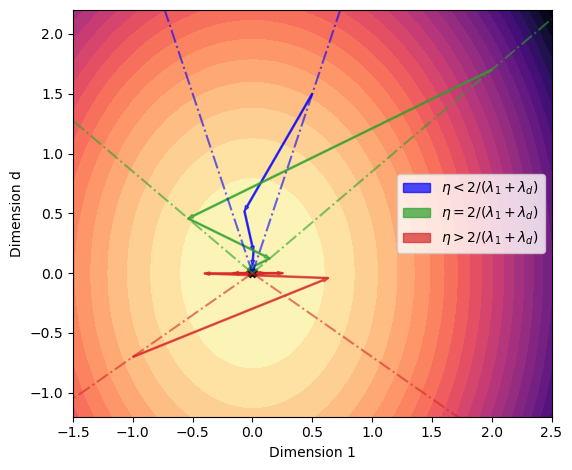

In [16]:
indices = [0, -1]
colors = ["blue", "C2", "C3"]
labels = [r"$\eta < 2 / (\lambda_1 + \lambda_d)$", r"$\eta = 2 / (\lambda_1 + \lambda_d)$", r"$\eta > 2 / (\lambda_1 + \lambda_d)$"]
gd_exs = gd_ec_betas
minimizer = np.zeros(d)

to_plot = [gd_exs.reshape(gd_exs.size // d, d), minimizer.reshape(1, d)]
mM = plotting.get_mM_around_trajectory(np.concatenate(to_plot))

fig, ax = plt.subplots(layout="tight")

plotting.contour_loss(ax, lambda x: loss_2d(x, d, indices, loss_func), mM, contour_levels=25)
for k, (gd_ex, color, label) in enumerate(zip(gd_exs, colors, labels)):
    plotting.plot_arrows(ax, gd_ex[:, 0], gd_ex[:, -1], color=color, alpha=.7, label=label)
    plotting.plot_semi_line(ax, minimizer[indices], gd_ex[0, indices], alpha=.6, ls='-.', color=color)
    plotting.plot_semi_line(ax, minimizer[indices], gd_ex[0, indices] * [-1, 1], alpha=.6, ls='-.', color=color)
    # ax.plot([minimizer[0], gd_ex[0, 0]], [minimizer[1], gd_ex[0, 1]], alpha=.6, ls='-.', c=f"C{k+2}")
    # ax.axline(minimizer, gd_ex[1], alpha=.4, ls='-.', c=f"C{k+2}")
plotting.plot_minimizer(ax, minimizer=minimizer)

ax.set_xlabel(f"Dimension 1")
ax.set_ylabel(f"Dimension d")
ax.legend()
ax.set_aspect("equal", "box")

path = os.path.join(img_dir, f"quad_gd_ec_trajectories.pdf")
fig.savefig(path)

plt.show()